#### demo2: Implementation of Euclidean distance to classify new profiles

In [1]:
import math, operator, gsw
import numpy as np
import pandas as pd
from netCDF4 import Dataset
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt

###############################################################
# Calculate Euclidean distance 
###############################################################
def distance(X, y, N):
	distance = 0
	for x in range(N):
		# Euclidean distance
		distance += (X[x] - y[x])**2
	return math.sqrt(distance)

###############################################################
# Get nearest centroid 
###############################################################
def getNearestCentroid(Xi, centroids):
	N = len(Xi)
	labels = list(range(len(centroids)))
	distances = []
	for key in labels:
		distances.append((key, distance(Xi, centroids[key], N)))
	distances.sort(key=operator.itemgetter(1))
	return distances[0][0]

###############################################################
# Iterate profiles
###############################################################
def NearestCentroid(X, centroids):
	#############################################################
	# parameters:
	# 	X: 2-D list, shape: [num_profiles, 1451 (depth)]
	# 	centroids: 2-D list, shape: [num_clusters, 1451 (depth)]

	predictions = []
	for i in range(len(X)):
		predictions.append(getNearestCentroid(X[i], centroids))
	return predictions

###############################################################
# Get interpolated data from Argo profiles
###############################################################
def getProfileData(file):
	# parameters:
	# 	file: String: full path of the profile file
 
	nc = Dataset(file)
	latitude = nc.variables['LATITUDE'][0]
	longitude = nc.variables['LONGITUDE'][0]
	df = pd.DataFrame({
		'pres': nc.variables['PRES_ADJUSTED'][0], 
		'psal': nc.variables['PSAL_ADJUSTED'][0], 
		'temp': nc.variables['TEMP_ADJUSTED'][0]
	})
	df = df.dropna()
	nc.close()
	
	less = df[df.pres <= 10].pres
	more = df[df.pres >= 1500].pres
	if (less.shape[0] == 0) | (more.shape[0] == 0):
		return pd.DataFrame([])
	
	# Here you can add the missing filters described in the manuscript or filters proposed by you.
 	# Remember to return an empty Pandas dataframe if the profile does not pass any filter.

	df = df[(df.pres >= less.values[-1]) & (df.pres <= more.values[0])].reset_index(drop=True)

	df['asal'] = gsw.SA_from_SP(df.psal.values, df.pres.values, np.repeat(longitude, df.shape[0]), np.repeat(latitude, df.shape[0]))
	df['ctemp'] = gsw.CT_from_t(df.asal.values, df.temp.values, df.pres.values)

	pres = np.arange(10, 1501, 1)
	t = interp1d(df.pres, df.ctemp)
	s = interp1d(df.pres, df.asal)
	interp_df = pd.DataFrame({
		'pres': pres, 
		'asal': s(pres), 
		'ctemp': t(pres)
	})
	return interp_df

To classify new profiles within the temperature and salinity clusters, the Euclidean distance is implemented.

Profiles with measurements from 10 to 1500 m are first selected and linearly interpolated at each meter of depth, as mentioned in the manuscript. For this demonstration, five DMQC random profiles were selected from the Argo snapshot used in the manuscript (check `README.md` file). To simplify the demo procedures, on this occasion we do not perform exhaustive filtering with these five profiles.

In [2]:
profile_files = ["D5904999_148.nc", "D3901116_098.nc", "D5904355_088.nc", "D2902612_192.nc", "D3900386_063.nc"]

files = []
pres = np.arange(10, 1501, 1).tolist()
ct_profiles = pd.DataFrame({}, columns=pres)
as_profiles = pd.DataFrame({}, columns=pres)

for file in profile_files:
    df = getProfileData(f"argo-profiles/{file}")
    # Adding datasets that did pass the filters
    if df.shape[0] > 0:
        files.append(file)
        ct_profiles.loc[len(ct_profiles.index)] = df.ctemp.values
        as_profiles.loc[len(as_profiles.index)] = df.asal.values

ct_profiles["file"] = files
as_profiles["file"] = files
print(f"{ct_profiles.shape[0]} interpolated conservative temperature profiles")
print(f"{as_profiles.shape[0]} interpolated absolute salinity profiles")

4 interpolated conservative temperature profiles
4 interpolated absolute salinity profiles


Now load the centroid files and use Euclidean distance to classify your profiles.

In [3]:
clusters = 5 # Number of centroids
df_ct = pd.read_csv(f'temperature-centroids/{str(clusters).zfill(2)}_centroids.csv') # For temperature centroids
df_as = pd.read_csv(f'salinity-centroids/{str(clusters).zfill(2)}_centroids.csv') # For salinity centroids

df = pd.DataFrame({
    "file": files,
    f"{clusters}_t": NearestCentroid(ct_profiles[pres].values, df_ct.T.values[1:]),
    f"{clusters}_s": NearestCentroid(as_profiles[pres].values, df_as.T.values[1:]),
})
df[f"{clusters}_th"] = df[f"{clusters}_t"].astype(str) + "_" + df[f"{clusters}_s"].astype(str)
df

,file,5_t,5_s,5_th
0,D5904999_148.nc,4,2,4_2
1,D3901116_098.nc,0,3,0_3
2,D5904355_088.nc,1,3,1_3
3,D2902612_192.nc,1,0,1_0


Now you can see your classified profiles on a map (see `demo1.ipynb`) or plot them on a T-S diagram.

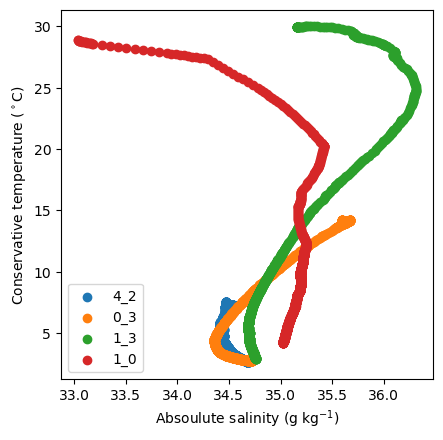

In [4]:
fig = plt.figure(figsize=(4.8, 4.8))
ax = fig.add_subplot(111)

for k in range(df.shape[0]):
    cte = ct_profiles[ct_profiles.file == df.file[k]]
    asa = as_profiles[as_profiles.file == df.file[k]]
    ax.scatter(asa[pres].values, cte[pres].values, label=df[f"{clusters}_th"][k])

ax.set_ylabel(r"Conservative temperature ($^\circ$C)")
ax.set_xlabel(r"Absoulute salinity (g kg$^{-1}$)")
ax.legend()